## Necessary Imports ##

In [1]:
import os
# os.environ['MUJOCO_GL'] = 'glfw' #'egl'
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import mujoco

print('Checking that the dm_control installation succeeded...')
try:
  from dm_control import suite
  env = suite.load('cartpole', 'swingup')
  pixels = env.physics.render()
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
  del pixels, suite

%load_ext autoreload

Checking that the dm_control installation succeeded...


In [2]:
#@title All `dm_control` imports required for this tutorial

# The basic mujoco wrapper.
from dm_control import mujoco as dm_mujoco

# Access to enums and MuJoCo library functions.
from dm_control.mujoco.wrapper.core import MjvOption
from dm_control.mujoco.wrapper.mjbindings import enums
from dm_control.mujoco.wrapper.mjbindings import mjlib

# PyMJCF
from dm_control import mjcf
from dm_control import viewer

# Composer high level imports
from dm_control import composer
from dm_control.composer.observation import observable
from dm_control.composer import variation

# Imports for Composer tutorial example
from dm_control.composer.variation import distributions
from dm_control.composer.variation import noises
from dm_control.locomotion.arenas import floors

# Control Suite
from dm_control import suite


# Manipulation
from dm_control import manipulation

# General
import copy
import os
import itertools
from IPython.display import clear_output
import numpy as np

# Graphics-related
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import IPython.display as display
import PIL.Image
# Internal loading of video libraries.

# Use svg backend for figure rendering
%config InlineBackend.figure_format = 'svg'

# Font sizes
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# # Inline video helper function
# if os.environ.get('COLAB_NOTEBOOK_TEST', False):
#   # We skip video generation during tests, as it is quite expensive.
#   display_video = lambda *args, **kwargs: None
# else:


from IPython.display import Video
def display_video(frames, framerate=30):
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  display.display(HTML(anim.to_html5_video()))


# Seed numpy's global RNG so that cell outputs are deterministic. We also try to
# use RandomState instances that are local to a single cell wherever possible.
np.random.seed(42)

/home/adityadutt/miniconda3/envs/roco/lib/python3.8/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


## Building the Environment using MJCF

In [3]:
from constants import *

#Handle Configs to work with SimRobot and MultiArmRRT
def append_robot_names(name, constants):
    result = dict()
    result["name"] = name
    for key, value in constants.items():
        #print(key)
        if key=='name':
            continue

        if key == "actuator_info":
            result[key] = {name + "/" + x: name + "/" + y for x, y in value.items()}
        elif key == "mesh_to_geoms":
            result[key] = {x: [name + "/" + y for y in z] for x, z in value.items()}

        elif isinstance(constants[key],str):
            result[key]= name+'/'+value
        else:
            result[key] = [name + "/" + x for x in value]

    return result

# Define your robot dictionary with all elements

In [4]:
robots = { 
            "panda": {
                "robot_config": append_robot_names("panda", PANDA_CONSTANTS.copy()),
                "robot_type": "panda",
                "file": 'assets/panda/panda.xml',
                "worldbody_site_pos": [0.4, -0.2, 0.2]
            
            },
            "ur5e":{
                "robot_config": append_robot_names("ur5e", UR5E_ROBOTIQ_CONSTANTS.copy()),
                "robot_type": "ur5e",
                "file": 'assets/ur5e_robotiq/ur5e_robotiq_full.xml',
                "worldbody_site_pos": [0.2, 1.2, 0.1]
            }
        }

## Define Base Class for the Task

In [5]:
from copy import deepcopy
from typing import Callable, List, Optional, Tuple, Union, Dict, Set, Any, FrozenSet

class BaseTask():
    # model = mjcf.RootElement()
    # physics = None
    def __init__(self, model_name:str = ""):
        self.model = mjcf.RootElement(model=model_name)

        ## Set the gloabl parameters
        self.global_params()

    def global_params(self,):
        self.model.compiler.angle = 'radian'
        self.model.compiler.autolimits = 'true'

        #Visual options
        self.model.visual.headlight.diffuse = [0.6, 0.6, 0.6] #Can use a list format or a string format
        self.model.visual.headlight.ambient=[0.1, 0.1, 0.1]
        self.model.visual.headlight.specular=[0, 0, 0]
        self.model.visual.rgba.haze = "0.15 0.25 0.35 1"
        self.model.visual.__getattr__('global').azimuth = 120 #Only way to access global attribute since gloabl is a Python keyword
        self.model.visual.__getattr__('global').elevation = -20
        self.model.visual.__getattr__('global').offwidth = 2000
        self.model.visual.__getattr__('global').offheight = 2000
        self.model.visual.quality.shadowsize = 4096

    def set_dclasses(self,):
        pass

    def render(self,):
        pass

    def set_physics(self,):
        self.physics = mjcf.Physics.from_mjcf_model(self.model)
    
    def build_scene(self, ):
        pass

## Define CabinetTask

In [12]:
TASK_OBJECTS = [["key_card", "right_door_handle", "table_top"]]

class CabinetTask(BaseTask):
    def __init__(self, model_name: str = "", robots = None, reset_to_home_pose = False, create_weld=False):
        
        super().__init__(model_name) 

        #Set default classes
        self.set_dclasses()
        #Build the scene
        self.build_scene()
        
        #Store Robot Configs
        self.robot_configs = {"panda": PANDA_CONSTANTS.copy(), "ur5e": UR5E_ROBOTIQ_CONSTANTS.copy(), 
                              "kinova": KINOVA_CONSTANTS.copy()}
    
        #Add Robots
        self.add_robots(robot_dict=robots, create_weld=create_weld)

        print("Add Robots Works!")

        #If add cameras:
        self.add_cameras()

        self.physics = mjcf.Physics.from_mjcf_model(self.model)

        self.joint_ids(robots)

        # self.create_SimRobots(robots= robots)

        print("Sim Robot Skip Works!")

        ## Compute Door Pose for Open-Door
        self.door_name = "cabinet/right_door_handle"
        self.cabinet_pos = self.physics.data.body("cabinet/cabinet").xpos.copy()
        self.open_door_pose = self.compute_door_open_pose(self.door_name) #[3, 4]

        ## Reset to home pose for now
        if reset_to_home_pose:
            self.reset_to_home_pose()
        
    def set_dclasses(self):
        #Default class values
        self.obj_visual_class = self.model.default.add('default', dclass="object_visual")
        self.obj_site_class = self.model.default.add('default', dclass='object_sites')
        self.obj_collision_class = self.model.default.add('default', dclass='object_collision')
        # obj_hingecabinet = self.model.default.add('default', dclass="hingecabinet")

        self.obj_visual_class.geom.type = 'mesh'
        self.obj_visual_class.geom.conaffinity = '0'
        self.obj_visual_class.geom.contype = '0'
        self.obj_visual_class.geom.group = '1'
        self.obj_visual_class.geom.mass = '0.00001'

        #add('site', type='cylinder', size='0.003 0.006', group=3)
        self.obj_site_class.site.type = 'cylinder'
        self.obj_site_class.site.size = '0.003 0.006'
        self.obj_site_class.site.group = 3           

        # <geom density="500" rgba="0.8 0.8 0.8 0.9" group="3"/>
        self.obj_collision_class.geom.density = '500'
        self.obj_collision_class.geom.rgba = '0.8 0.8 0.8 0.9'
        self.obj_collision_class.geom.group = 3

    def build_scene(self):
        #Floor and initial light
        self.model.worldbody.add('light', pos="0 0 1.5", dir="0 0 -1", directional="true")

        self.groundplane_texture = self.model.asset.add('texture', type="2d", name="groundplane", builtin="checker", mark="edge", rgb1="0.2 0.3 0.4", rgb2="0.1 0.2 0.3", markrgb="0.8 0.8 0.8", width="300", height="300")
        self.groundplane_mat = self.model.asset.add('material', name="groundplane", texture="groundplane", texuniform="true", texrepeat="2 2", reflectance="0.2")
        self.groundplane = self.model.worldbody.add('geom', name="floor", pos="0 0 -0.5", size="0 0 0.05", type="plane", material="groundplane")

        #Adding the table box
        self.table_box = self.model.worldbody.add('body', name="table", pos="0 0.5 0")
        self.table_box.add('geom', name="table_collision", pos="0 0 0.1", size="1.6 .5 0.05", type="box") #friction="1 0.005 0.0001")
        # self.table_box.add('geom', material="white-wood", name="table-mat")

        self.table_top = self.table_box.add('body', name="table_top", pos="0 0 0.11")
        self.table_top.add('geom', name="table_top", size="1.6 0.4 0.05", type="box", conaffinity="0", contype="0", group="1")
        # table_top.add('site', name="table_top", size="0.001 0.001 0.001", class_="site_top")

        self.table_box.add('geom', name="table_left", pos="-1.63 0 1", size="0.02 1.6 1.5", rgba="1 1 1 0", type="box")
        self.table_box.add('geom', name="table_right", pos="1.63 0 1", size="0.02 1.6 1.5", rgba="1 1 1 0", type="box")
        self.table_box.add('geom', name="table_front", pos="0 1.63 1", size="1.7 0.02 1.5", rgba="1 1 1 0", type="box")
        self.table_box.add('geom', name="table_back", pos="0 -1.63 1", size="1.7 0.02 1.5", rgba="1 1 1 0", type="box")

        #Adding a key card on the table
        self.key_card = self.model.worldbody.add('body', name="keycard", pos="0.5 0.6 0.1")

        #Can also do add_free_joint()
        self.key_card.add('freejoint', name="keycard_joint") #, type="free", name="keycard_joint", pos="0 0 0", axis="0 0 1")
        self.key_card.add('geom', name='keycard', type="box", rgba="0. 0. 0. 1", size="0.05 0.1 0.01")

        #Add the cabinet    
        self.cabinet_path = "assets/cabinet/cabinet_mjcf.xml"
        self.cabinet =  mjcf.from_file(self.cabinet_path)
        self.cabinet.model = "cabinet"
        self.model.attach(self.cabinet)

        #Add the camera
        self.camera = self.model.worldbody.add('camera', name='my_camera', pos="2.1 -0.15 1.731", xyaxes="0.487 0.874 0.000 -0.500 0.278 0.820")

        ## Add Goal Poses as mocap bodies
        self.mocap_body = self.model.worldbody.add('body', name="goal", mocap=True, pos="0 0 0.1", quat="1 0 0 0")

    def add_cameras(self):
        self.model.worldbody.add('camera', mode="fixed", name='face_panda1', pos="0.062 -2.806 0.768", xyaxes="1.000 0.009 -0.000 0.001 -0.131 0.991")
        self.model.worldbody.add('camera', mode="fixed", name='face_panda2', pos="0.084 3.711 0.772", xyaxes="-1.000 0.016 0.000 0.002 0.111 0.994")
        self.model.worldbody.add('camera', mode="fixed", name='top_cam', pos="-0.001 0.652 2.057", xyaxes="-1.000 -0.000 -0.000 0.000 -1.000 0.019")
        self.model.worldbody.add('camera', mode="fixed", name='right_cam', pos="1.873 0.605 0.926", xyaxes="0.014 1.000 0.000 -0.242 0.003 0.970")
        self.model.worldbody.add('camera', mode="fixed", name='left_cam', pos="-1.873 0.605 0.926", xyaxes="-0.000 -1.000 0.000 0.177 -0.000 0.984")
        self.model.worldbody.add('camera', name='teaser', pos="2.675 -0.747 1.997", xyaxes="0.496 0.869 -0.000 -0.429 0.245 0.869")
        self.model.worldbody.add('camera', name='video', pos="1.957 -0.281 1.731", xyaxes="0.487 0.874 0.000 -0.500 0.278 0.820")

    def render_scene(self, ctrl: dict, duration, framerate, cam: int, width=800, height=800):
        # Simulate and display video.
        frames = []
        self.physics.reset()  # Reset to keyframe 0 (load a saved state).
        while self.physics.data.time < duration:
            self.physics.data.ctrl[ctrl["ctrl_idxs"]] = ctrl["ctrl_vals"]
            self.physics.step()
            if len(frames) < (self.physics.data.time) * framerate:
                pixels = self.physics.render(camera_id=cam, width=width, height=height)
                frames.append(pixels)

        display_video(frames, framerate)

    def render_image(self, cam_id:int = 0, qpos = None, qpos_id = None, width=1080, height=800):
        if qpos == None:
            self.physics.reset()
            img = PIL.Image.fromarray(self.physics.render(camera_id=cam_id, width = width, height = height))
        else:
            with self.physics.reset_context():
                self.physics.data.qpos[qpos_id] = qpos
                self.physics.step()

                img = PIL.Image.fromarray(self.physics.render(camera_id=cam_id, width = width, height = height))
        return img

    def add_robots(self, robot_dict, create_weld = False):
        self.robot_models = {}

        for robot_name, robot_data in robot_dict.items():   
            
            #Create robot model to attach to mujoco world model
            robot = mjcf.from_path(robot_data["file"])
            robot.model = robot_name
            robot_site = self.model.worldbody.add('site', name=robot_name, pos=robot_data["worldbody_site_pos"], size=[0.001, 0.001, 0.001])
            robot_site.attach(robot)
            self.robot_models[robot_name] = deepcopy(robot)
            del robot, robot_site
        
        #Add weld connections -> Add Adhesion instead
        if create_weld:
            self.model.equality.add("weld", name="door_handle_panda", body1="cabinet/right_door_handle", body2="ur5e/robotiq_tip", relpose=[0,0, 0, 1, 0, 0, 0], active=False)
            self.model.equality.add("weld", name="keycard_panda", body1="keycard", body2="panda/panda_palm", relpose=[0,0, 0, 1, 0, 0, 0], active=False)
    
    def joint_ids(self,robots):
        self.joint_ids = {}
        for robot_name, robot_data in robots.items():
            qpos_idx = []
            ctrl_idx = []
            for _name in robot_data["robot_config"]["ik_joint_names"]:
                qpos_slice = self.physics.named.data.qpos._convert_key(_name)
                assert int(qpos_slice.stop - qpos_slice.start) == 1, "Only support single joint for now"
                idx_in_qpos = qpos_slice.start
                qpos_idx.append(idx_in_qpos)
                # self.joint_ranges.append(self.physics.model.joint(_name).range)

                assert _name in robot_data["robot_config"]["actuator_info"], f"Joint {_name} not in actuator_info"
                actuator_name = robot_data["robot_config"]["actuator_info"][_name]
                idx_in_ctrl = self.physics.named.data.ctrl._convert_key(actuator_name)
                ctrl_idx.append(idx_in_ctrl)
            
            self.joint_ids[robot_name] = {"qpos": qpos_idx, "ctrl": ctrl_idx}
    # def create_SimRobots(self, robots = None):
        
    #     #Create new config based on which robot it is
    #     #Dictionary storing the SimRobot instances of all robots
    #     self.sim_robots = {}
    #     self.joint_ids = {}

    #     for robot_name, robot_data in robots.items():  
    #         # new_config = append_robot_names(robot_name, self.robot_configs[robot_data["robot_type"]])

    #         #Create SimRobot instances
    #         self.sim_robots[robot_name] = SimRobot(physics=self.physics, **robot_data["robot_config"])

    #         self.joint_ids[robot_name] = {
    #                                     "qpos":self.sim_robots[robot_name].joint_idxs_in_qpos, 
    #                                       "ctrl":self.sim_robots[robot_name].joint_idxs_in_ctrl
    #                                       }

    def get_goal_pose(self,):
        return np.concatenate([task.physics.named.data.mocap_pos["goal"][:], task.physics.named.data.mocap_quat["goal"][:]])
    
    def get_robot_pose(self, robot_name):
        return np.concatenate((self.physics.named.data.xpos[robot_name],self.physics.named.data.xquat[robot_name]),axis=0)

    def compute_door_open_pose(self, door_name: str = "cabinet/right_door_handle"):
        physics = self.physics.copy(share_model=True)
        # if door_name == "left_door_handle":p
        #     qpos_slice = self.physics.named.data.qpos._convert_key("leftdoorhinge")
        #     if self.cabinet_pos[0] > 0:
        #         physics.data.qpos[qpos_slice.start] = -2.2
        #     else:
        #         physics.data.qpos[qpos_slice.start] = -2.6
        # elif door_name == "right_door_handle":
        qpos_slice = self.physics.named.data.qpos._convert_key("cabinet/rightdoorhinge")
        if self.cabinet_pos[0] > 0:
            physics.data.qpos[qpos_slice.start] = 1.8    
        else:
            physics.data.qpos[qpos_slice.start] = 1.
        # else:
        #     raise NotImplementedError
        physics.forward()
        desired_handle_pose = np.concatenate(
            [physics.data.body(door_name).xpos, physics.data.body(door_name).xquat]
        ) 
        # img = physics.render(camera_id="teaser")
        # plt.imshow(img)
        # plt.show()
        del physics 
        return desired_handle_pose   

    def reset_to_home_pose(self, joint_ids = None, render=False):

        if joint_ids is None:
            joint_ids = self.joint_ids.copy()

        self.physics.reset()
        # with task.physics.reset_context():
        # self.physics.named.model.eq_active["keycard_panda"] = False
        self.physics.named.data.qpos["keycard_joint"] = [0.5, 0.5, 0.17, 1., 0., 0., 0.]
        # self.physics.named.model.eq_active["door_handle_panda"] = False
            # qpos="0 0 0 -1.57079 0 1.57079 -0.7853 0.04 0.04"
            # physics.data.qpos[joint_ids["panda1"]["qpos"] + joint_ids["panda2"]["qpos"]] = [0., 0., 0., 0., -1.57079, 0, 1.57079, -0.7853]*2 
        if "ur5e" in joint_ids.keys():
            self.physics.data.qpos[joint_ids["ur5e"]["qpos"]] = [0.0, -1.5708, -1.5708, 1.5708, -1.5708, -1.5708, 0.] # (8, 9, 10, 11, 12, 13, 14)
        if "panda" in joint_ids.keys():
            self.physics.data.qpos[joint_ids["panda"]["qpos"]] = [0., 0., -1.3, 0., -2.5, 0, 1., 0.]
        if "kinova" in joint_ids.keys():
            self.physics.data.qpos[joint_ids["kinova"]["qpos"]] = [0.0411018, 1.57, -0.31415, 0.06283, -1.19377, -0.06283, -1.44509, 1.67465]
        ##Kinova home pos
        # physics.data.qpos[np.arange(33, 41)] = [0.0411018, 1.57, -0.31415, 0.06283, -1.19377, -0.06283, -1.44509, 1.67465]

        self.physics.data.ctrl = 0.
        self.physics.data.qvel = 0.
        self.physics.step()

        if render:
            img = PIL.Image.fromarray(self.physics.render(camera_id=6, width=1080, height=800))
            return img
        
        return None

    ## traj is full traj for all robot joints
    def visualize_traj(self, traj: Dict[str, Any], grasps: Dict[str, int] = None, 
                       framerate: int = 30, control_rate: float = 0.01, duration: int = 5):
        
        frames = []

        #Reset to home pose for visualization
        self.reset_to_home_pose()
        
        # task.physics.named.model.eq_active["keycard_panda"] = False
        # task.physics.named.data.ctrl["panda1/panda_gripper_actuator"] = 255
        self.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 255
        self.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 255

        ### Define Grasp Indices ###
        if grasps is not None:
            key_grasp_idx = grasps["keycard"]
            door_grasp_idx = grasps["door"]

        # Simulate and display video.
        while self.physics.data.time < duration:
            t0 = self.physics.data.time
            idx = int(self.physics.data.time/ control_rate)

            if idx >= len(traj):
                idx = len(traj) - 1
            
            if key_grasp_idx is not None and idx >= key_grasp_idx:
                self.physics.named.data.ctrl["panda2/panda_gripper_actuator"] = 0
                self.physics.named.model.eq_active["keycard_panda"] = True


            if door_grasp_idx is not None and idx >= door_grasp_idx:
                self.physics.named.data.ctrl["ur5e/robotiq_fingers_actuator"] = 0
                self.physics.named.model.eq_active["door_handle_panda"] = True

            for name, robot_joints in self.joint_ids:
                self.physics.data.ctrl[robot_joints["ctrl"]] = traj[name][idx]

            while self.physics.data.time - t0 < control_rate:
                self.physics.step()
                if len(frames) < self.physics.data.time * framerate:
                    pixels = self.physics.render(camera_id=0, width=1080,height=800)#, scene_option=scene_option), render_flag_overrides={mujoco.mjtRndFlag.mjRND_REFLECTION: False})
                    frames.append(pixels)

task = CabinetTask(robots = robots)

Add Robots Works!
Sim Robot Skip Works!


## Visualize the Scene

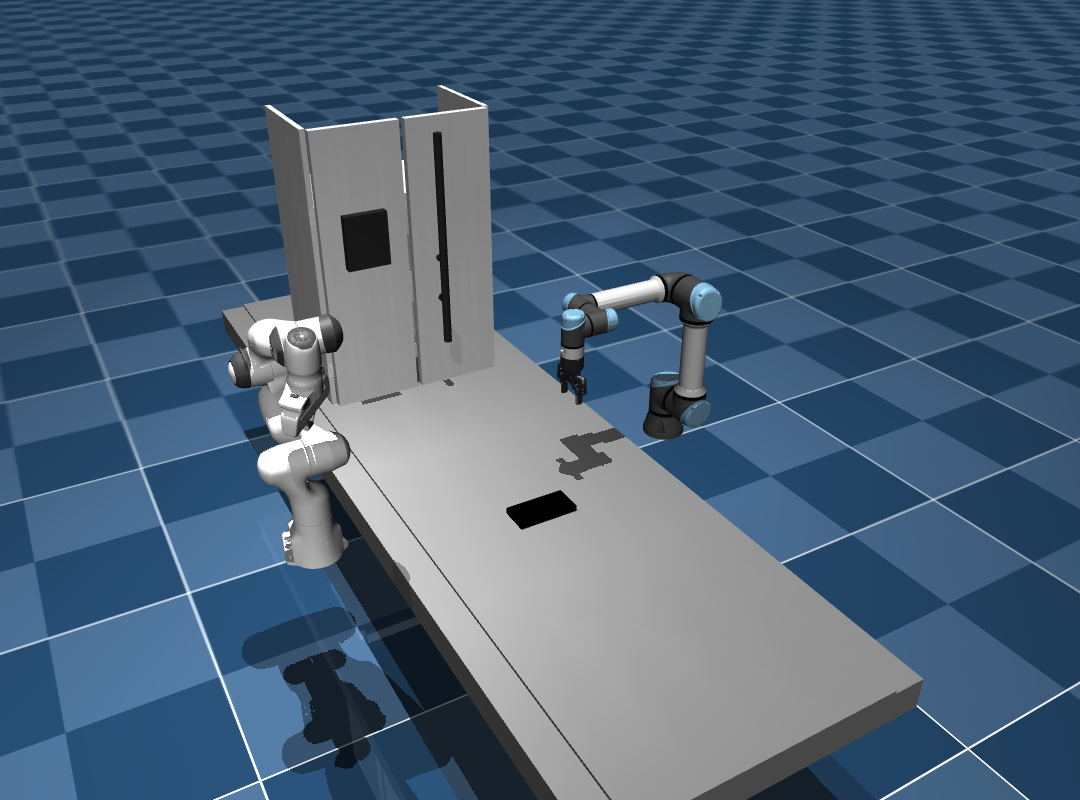

In [13]:
## Rendering the scene
task.reset_to_home_pose(render=True)

## Note down the Q Pos of all the movable objects along with their names

In [8]:
## Info of QPos and Geoms ##
print(task.physics.named.data.qpos)

FieldIndexer(qpos):
 0                   keycard_joint [ 0.5     ]
 1                   keycard_joint [ 0.5     ]
 2                   keycard_joint [ 0.17    ]
 3                   keycard_joint [ 1       ]
 4                   keycard_joint [ 8.24e-19]
 5                   keycard_joint [ 3.33e-16]
 6                   keycard_joint [-3.33e-20]
 7          cabinet/rightdoorhinge [ 0       ]
 8          panda/panda_base_joint [-1.13e-05]
 9                    panda/joint1 [-1.3     ]
10                    panda/joint2 [-8.28e-05]
11                    panda/joint3 [-2.5     ]
12                    panda/joint4 [-0.000295]
13                    panda/joint5 [ 1       ]
14                    panda/joint6 [ 0.000663]
15                    panda/joint7 [-0.000319]
16             panda/finger_joint1 [ 1.87e-05]
17             panda/finger_joint2 [-1.87e-05]
18          ur5e/ur5e_0_base_joint [ 1.79e-07]
19  ur5e/ur5e_0_shoulder_pan_joint [-1.57    ]
20 ur5e/ur5e_0_shoulder_lift_joint [-1.5

In [29]:
## Uncomment these to check the different indexes into qpos and ctrl of the environment
# print(task.joint_ids["panda"]["ctrl"], task.joint_ids["panda"]["qpos"])
# print(task.physics.model.actuator_ctrlrange[task.joint_ids["panda"]["ctrl"]])

## PREDICTIVE SAMPLING using MUJOCO MPC

In [13]:
# Copyright 2023 DeepMind Technologies Limited
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

from __future__ import annotations

import bisect
from typing import Callable, Tuple

import mujoco
import numpy as np


# predictive sampling
# https://arxiv.org/abs/2212.00541


class Policy:
  """Policy class for predictive sampling."""

  def __init__(
      self,
      naction: int,
      horizon: float,
      splinestep: float,
      interp: str = "zero",
      limits: np.ndarray | None = None):
    """Initialize policy class.

    Args:
        naction: number of actions
        horizon: planning horizon (seconds)
        splinestep: interval length between spline points
        interp (optional): type of action interpolation. Defaults to "zero".
        limits (optional): lower and upper bounds on actions. Defaults to None.
    """
    self._naction = naction #8 for panda arm with base
    self._splinestep = splinestep
    self._horizon = horizon
    self._nspline = int(horizon / splinestep) + 1
    self._parameters = np.zeros((self._naction, self._nspline), dtype=float)
    self._times = np.array(
        [t * self._splinestep for t in range(self._nspline)], dtype=float
    )
    self._interp = interp
    self._limits = limits

  def _find_interval(
      self, sequence: np.ndarray, value: float
  ) -> Tuple[int, int]:
    """Find neighboring indices in sequence containing value.

    Args:
        sequence: array of values
        value: value to find in interval

    Returns:
        lower and upper indices in sequence containing value
    """
    # bisection search to get interval
    upper = bisect.bisect_right(sequence, value)
    lower = upper - 1

    # length of sequence
    L = len(sequence)

    # return feasible interval
    if lower < 0:
      return (0, 0)
    if lower > L - 1:
      return (L - 1, L - 1)
    return (max(lower, 0), min(upper, L - 1))

  def _slope(
      self, times: np.ndarray, params: np.ndarray, value: float
  ) -> np.ndarray:
    """Compute interpolated slope vector at value.

    Args:
        times: sequence of time markers
        params: sequence of vectors
        value: input where to compute slope

    Returns:
        interpolated slope vector
    """
    # bounds
    bounds = self._find_interval(times, value)

    times_length = len(times)

    # lower out of bounds
    if bounds[0] == 0 and bounds[1] == 0:
      if times_length > 2:
        return (params[:, bounds[1] + 1] - params[:, bounds[1]]) / (
            times[bounds[1] + 1] - times[bounds[1]]
        )
      return np.zeros(params.shape[0])

    # upper out of bounds
    if bounds[0] == times_length - 1 and bounds[1] == times_length - 1:
      if times_length > 2:
        return (params[:, bounds[0]] - params[:, bounds[0] - 1]) / (
            times[bounds[0]] - times[bounds[0] - 1]
        )
      return np.zeros(params.shape[0])

    # lower boundary
    if bounds[0] == 0:
      return (params[:, bounds[1]] - params[:, bounds[0]]) / (
          times[bounds[1]] - times[bounds[0]]
      )

    # internal interval
    return 0.5 * (params[:, bounds[1]] - params[:, bounds[0]]) / (
        times[bounds[1]] - times[bounds[0]]
    ) + 0.5 * (params[:, bounds[0]] - params[:, bounds[0] - 1]) / (
        times[bounds[0]] - times[bounds[0] - 1]
    )

  def action(self, time: float) -> np.ndarray:
    """Return action from policy at time.

    Args:
        time: time value to evaluate plan for action

    Returns:
        interpolated action at time
    """
    # find interval containing time
    bounds = self._find_interval(self._times, time)

    # boundary case
    if bounds[0] == bounds[1]:
      return self.clamp(self._parameters[:, bounds[0]])

    # normalized time
    t = (time - self._times[bounds[0]]) / (
        self._times[bounds[1]] - self._times[bounds[0]]
    )

    if self._interp == "cubic":
      # spline coefficients
      c0 = 2.0 * t * t * t - 3.0 * t * t + 1.0
      c1 = (t * t * t - 2.0 * t * t + t) * (
          self._times[bounds[1]] - self._times[bounds[0]]
      )
      c2 = -2.0 * t * t * t + 3 * t * t
      c3 = (t * t * t - t * t) * (
          self._times[bounds[1]] - self._times[bounds[0]]
      )

      # slopes
      m0 = self._slope(self._times, self._parameters, self._times[bounds[0]])
      m1 = self._slope(self._times, self._parameters, self._times[bounds[1]])

      # interpolation
      return self.clamp(
          c0 * self._parameters[:, bounds[0]]
          + c1 * m0
          + c2 * self._parameters[:, bounds[1]]
          + c3 * m1
      )
    elif self._interp == "linear":
      return self.clamp(
          (1.0 - t) * self._parameters[:, bounds[0]]
          + t * self._parameters[:, bounds[1]]
      )
    else:  # self._interp == "zero"
      return self.clamp(self._parameters[:, bounds[0]])

  def resample(self, time: float):
    """Resample plan starting from time.

    Args:
        time: time value to start updated plan
    """
    # new times and parameters
    times = np.array(
        [i * self._splinestep + time for i in range(self._nspline)], dtype=float
    )
    parameters = np.vstack([self.action(t) for t in times]).T

    # update
    self._times = times
    self._parameters = parameters

  def add_noise(self, scale: float):
    """Add zero-mean Gaussian noise to plan.

    Args:
        scale: standard deviation of zero-mean Gaussian noise
    """
    # clamp within limits
    self._parameters = self.clamp(
        self._parameters
        + np.random.normal(scale=scale, size=(self._naction, self._nspline))
    )

  def noisy_copy(self, scale: float) -> Policy:
    """Return a copy of plan with added noise.

    Args:
        scale: standard deviation of zero-mean Gaussian noise

    Returns:
        copy of policy object with noisy plan
    """
    # create new policy object
    policy = Policy(self._naction, self._horizon, self._splinestep)

    # copy policy parameters into new object
    policy._parameters = np.copy(self._parameters)

    # get noisy parameters
    policy.add_noise(scale)

    return policy

  def clamp(self, action: np.ndarray) -> np.ndarray:
    """Return input clamped between limits.

    Args:
        action: input vector

    Returns:
        clamped input vector
    """
    # clamp within limits
    if self._limits is not None:
      return np.minimum(
          np.maximum(self._limits[:, 0], action), self._limits[:, 1]
      )
    return action

def rollout(
    qpos: np.ndarray,
    qvel: np.ndarray,
    act: np.ndarray,
    time: float,
    mocap_pos: np.ndarray,
    mocap_quat: np.ndarray,
    physics: mjcf.Physics,
    #model: mujoco.MjModel,
    #data: mujoco.MjData,
    reward: Callable,
    policy: Policy,
    horizon: float,
) -> float:
  """Return total return by rollout out plan with forward dynamics.

  Args:
      qpos: initial configuration
      qvel: initial velocity
      act: initial activation
      time: current time
      mocap_pos: motion-capture body positions
      mocap_quat: motion-capture body orientations
      model: MuJoCo model
      data: MuJoCo data
      reward: function returning per-timestep reward value
      policy: plan for computing action at given time
      horizon: planning duration (seconds)

  Returns:
      total return (normalized by number of planning steps)
  """
  model = physics.model
  data = physics.data

  ctrl_idxs = task.joint_ids["panda"]["ctrl"]
  # number of steps
  steps = int(horizon / model.opt.timestep)

  # reset data
  # mujoco.mj_resetData(model, data)
  physics.reset()

  # initialize state
  data.qpos = qpos
  data.qvel = qvel
  data.act = act
  data.time = time
  data.mocap_pos = mocap_pos
  data.mocap_quat = mocap_quat

  # initialize reward
  total_reward = 0.0

  end_effector = "panda/panda_palm"
  # goal_pose = np.array([])

  # simulate
  for _ in range(steps):
    # get action from policy
    data.ctrl[ctrl_idxs] = policy.action(data.time)

    # evaluate current reward
    total_reward += reward(physics, end_effector)

    # step dynamics
    # mujoco.mj_step(model, data)
    physics.step()

  # terminal reward
  data.ctrl[ctrl_idxs] = np.zeros(8) #ctrl values = 8
  total_reward += reward(physics, end_effector)

  return total_reward / (steps + 1)

class Planner:
  """Predictive sampling planner class."""

  def __init__(
      self,
      physics: mjcf.Physics,
      # model: mujoco.MjModel,
      reward: Callable,
      horizon: float,
      splinestep: float,
      planstep: float,
      nsample: int,
      noise_scale: float,
      nimprove: int,
      interp: str = "zero",
      limits: bool = True,
  ):
    """Initialize planner.

    Args:
        model: MuJoCo model
        reward: function returning per-timestep reward value
        horizon: planning duration (seconds)
        splinestep: interval length between spline points
        planstep: interval length between forward dynamics steps
        nsample: number of noisy plans to evaluate
        noise_scale: standard deviation of zero-mean Gaussian
        nimprove: number of iterations to improve plan for fixed initial
          state
        interp: type of action interpolation. Defaults to
          "zero".
        limits: lower and upper bounds on action. Defaults to
          True.
    """

    self.physics = physics.copy()

    self._model = physics.model.__copy__()
    self._model.opt.timestep = planstep
    # self._data = mujoco.MjData(self._model)
    self._data = physics.data
    self._reward = reward
    self._horizon = horizon


    ## Policy just to control Panda arm ##
    self.policy = Policy(
        8,#physics.model.nu,
        self._horizon,
        splinestep,
        interp=interp,
        limits=physics.model.actuator_ctrlrange[task.joint_ids["panda"]["ctrl"]] if limits else None,
    )
    self._nsample = nsample
    self._noise_scale = noise_scale
    self._nimprove = nimprove

  def action_from_policy(self, time: float) -> np.ndarray:
    """Return action at time from policy.

    Args:
        time: time to evaluate plan for action

    Returns:
        action interpolation at time
    """
    return self.policy.action(time)

  def improve_policy(
      self,
      qpos: np.ndarray,
      qvel: np.ndarray,
      act: np.ndarray,
      time: float,
      mocap_pos: np.ndarray,
      mocap_quat: np.ndarray,
  ):
    """Iteratively improve plan via searching noisy plans.

    Args:
        qpos: initial configuration
        qvel: initial velocity
        act: initial activation
        time: current time
        mocap_pos: motion-capture body position
        mocap_quat: motion-capture body orientation
    """
    # resample
    self.policy.resample(time)

    for _ in range(self._nimprove):
      # evaluate nominal policy
      reward_nominal = rollout(
          qpos,
          qvel,
          act,
          time,
          mocap_pos,
          mocap_quat,
          self.physics,
          # self._model,
          # self._data,
          self._reward,
          self.policy,
          self._horizon,
      )

      # evaluate noisy policies
      policies = []
      rewards = []

      for _ in range(self._nsample):
        # noisy policy
        noisy_policy = self.policy.noisy_copy(self._noise_scale)
        noisy_reward = rollout(
            qpos,
            qvel,
            act,
            time,
            mocap_pos,
            mocap_quat,
            self.physics,
            # self._model,
            # self._data,
            self._reward,
            noisy_policy,
            self._horizon,
        )

        # collect result
        policies.append(noisy_policy)
        rewards.append(noisy_reward)

      # find best policy
      idx = np.argmax(rewards)

      # return new policy
      if rewards[idx] > reward_nominal:
        self.policy = policies[idx]


## Define a Reward Function 

In [14]:
## For Now: Obstacle Avoidance constraint has been removed to decrease reward complexity
def reward(physics, end_effector):
    r = 0.0

    #Goal Pose and Quat
    goal_pose = physics.named.data.mocap_pos["goal"]
    goal_quat = physics.named.data.mocap_quat["goal"]

    pos_error = physics.named.data.xpos[end_effector] - goal_pose
    r_pose = - np.dot(pos_error, pos_error)

    subquat = np.zeros(3)
    mujoco.mju_subQuat(subquat, goal_quat, physics.named.data.xquat[end_effector])

    r_quat = - 0.5 * np.dot(subquat, subquat)

    # Obstacle Avoidance
    r_obs = 0.0 #np.linalg.norm()

    # Velocity for smoothness
    r_vel = -np.dot(physics.data.qvel, physics.data.qvel)

    # effort
    r_effort = -np.dot(physics.data.ctrl, physics.data.ctrl)

    ## Weights are hyperparameters that can be tuned
    r = 20.0 * r_pose + 10 * r_quat + r_obs + 2 * r_vel + 2 * r_effort
    return r

horizon = 0.5
splinestep = 0.1
planstep = 0.025
nimprove = 10
nsample = 10
noise_scale = 0.01
interp = "zero"
planner = Planner(
    task.physics,
    reward,
    horizon,
    splinestep,
    planstep,
    nsample,
    noise_scale,
    nimprove,
    interp=interp,
)

In [30]:
# simulate
import mediapy as media

task.physics.reset()
steps = 1000
tol = 1e-6

data = task.physics.data
model = task.physics.model

# history
qpos = [data.qpos]
qvel = [data.qvel]
act = [data.act]
ctrl = []
rewards = []

# frames
frames = []
FPS = 1.0 / model.opt.timestep

# verbose
VERBOSE = True

### Goal Pose is Panda move to Keycard
goal_pose = task.physics.named.data.xpos["keycard"] + np.array([0., 0., .5])
end_effector = "panda/panda_palm"

for i in range(steps):
  ## predictive sampling

  # improve policy
  planner.improve_policy(
      data.qpos, data.qvel, data.act, data.time, data.mocap_pos, data.mocap_quat
  )

  # get action from policy
  data.ctrl[task.joint_ids["panda"]["ctrl"]] = planner.action_from_policy(data.time)
  # data.ctrl = np.random.normal(scale=0.1, size=model.nu)

  # reward
  rewards.append(reward(task.physics, end_effector))

  if VERBOSE:
    print("time  : ", data.time)
    print(" qpos  : ", data.qpos)
    print(" qvel  : ", data.qvel)
    print(" act   : ", data.act)
    print(" action: ", data.ctrl)
    print(" reward: ", rewards[-1])

  # step
  task.physics.step()
  # mujoco.mj_step(model, data)

  # history
  qpos.append(data.qpos)
  qvel.append(data.qvel)
  act.append(data.act)
  ctrl.append(data.ctrl)

  # print(data.sensor("cube_goal_orientation").data)
  # render and save frames
  # renderer.update_scene(data)
  pixels = task.render_image()
  frames.append(pixels)

  if i > 5 and (np.linalg.norm(rewards[-1] - rewards[-2])< tol):
    break
# %%
# media.show_video(frames, fps=FPS)


time  :  0.0
 qpos  :  [0.5 0.6 0.1 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 qvel  :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
 act   :  []
 action:  [-0.55583259 -0.08049408 -0.0230531  -0.05748836 -0.06633737 -0.10075315
  0.01124461  0.04487103  0.          0.          0.          0.
  0.          0.          0.          0.          0.        ]
 reward:  -27.98216552859189
time  :  0.0
 qpos  :  [0.5 0.6 0.1 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 qvel  :  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
 act   :  []
 action:  [-0.55583259 -0.08049408 -0.0230531  -0.05748836 -0.06633737 -0.10075315
  0.01124461  0.04487103  0.          0.          0.          0.
  0.          0.          0.          0.          0.   

KeyboardInterrupt: 

8 (33,)
8 (32,)
8 (0,)
7 (17,)
7 -27.98216552859189


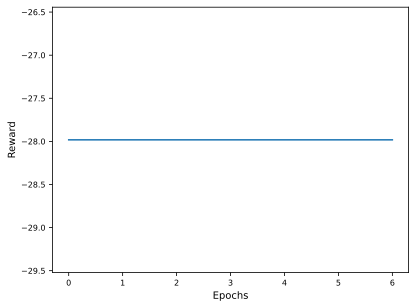

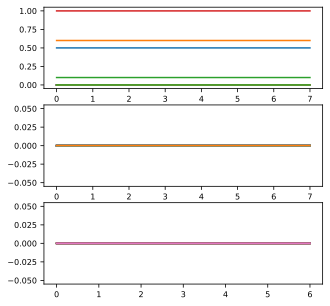

In [27]:
### Plot the results ###
print(len(qpos), qpos[0].shape)
print(len(qvel), qvel[0].shape)
print(len(act), act[0].shape)
print(len(ctrl), ctrl[0].shape)
print(len(rewards), rewards[0])


### Plot the reward function:
plt.figure()
plt.plot(rewards, label="rewards")
plt.xlabel("Epochs")
plt.ylabel("Reward")
plt.show()

## Plot the states and controls ##
fig, ax = plt.subplots(3,1, figsize=((5,5)))
ax[0].plot(qpos)
ax[1].plot(qvel)
ax[2].plot(ctrl)
plt.show()



## Predictive Sampling FAILED!

Problems:
1. Difficult to manually design reward for complex setting such as multi-robot planning. 
2. Exploration Space is too large for size of QPOS
3. Policy Improvement Step is not taking large enough steps and hence not improving

# MPC using Curobo

In [14]:
### Imports ###
import copy
from copy import deepcopy

import curobo
import torch

from curobo.types.math import Pose
from curobo.types.robot import JointState
from curobo.wrap.reacher.motion_gen import MotionGen, MotionGenConfig, MotionGenPlanConfig
from curobo.geom.types import WorldConfig, Cuboid, Mesh, Capsule, Cylinder, Sphere

device = 'cuda:0'

## Import MPC Functions
from curobo.wrap.reacher.mpc import MpcSolver, MpcSolverConfig
from curobo.types.state import JointState
from curobo.rollout.rollout_base import Goal

## World Config Generation Class
import world_config

## Import importlib for debugging
import importlib



## Generating the World Configuration Files needed for Curobo

In [15]:
panda_assets_path = "robot/franka_description"
robotiq_assets_path = "robot"

panda_constants = append_robot_names("panda", PANDA_CONSTANTS.copy())
ur5e_constants = append_robot_names("ur5e", UR5E_ROBOTIQ_CONSTANTS.copy())
panda_meshes = panda_constants["mesh_to_geoms"]
ur5e_meshes = ur5e_constants["mesh_to_geoms"]

mesh_dict = {}

for key, v in panda_meshes.items():
    mesh_dict[ panda_assets_path + '/' + key] = v
    # panda_mesh_dict[key] = v

for key, v in ur5e_meshes.items():
    # mesh_dict[ur5e_assets_path + '/' + key] = v
    # panda_mesh_dict[key] = v
    mesh_dict[ robotiq_assets_path + '/' + key] = v

print(mesh_dict.keys())

dict_keys(['robot/franka_description/assets/link0.stl', 'robot/franka_description/assets/link1.stl', 'robot/franka_description/assets/link2.stl', 'robot/franka_description/assets/link3.stl', 'robot/franka_description/assets/link4.stl', 'robot/franka_description/assets/link5_collision_0.obj', 'robot/franka_description/assets/link5_collision_1.obj', 'robot/franka_description/assets/link5_collision_2.obj', 'robot/franka_description/assets/link6.stl', 'robot/franka_description/assets/link7.stl', 'robot/franka_description/assets/hand.stl', 'robot/franka_description/assets/finger_0.obj', 'robot/robotiq_assets/base_mount.stl', 'robot/robotiq_assets/base.stl', 'robot/robotiq_assets/driver.stl', 'robot/robotiq_assets/coupler.stl', 'robot/robotiq_assets/spring_link.stl', 'robot/robotiq_assets/follower.stl'])


In [16]:
panda_world_config = world_config.WorldConfig()
panda_world_config.generate_world_config(task.physics, mesh_test=False, skip_robot_name="panda")
panda_world_config.update_curobo_world(physics = task.physics, robot_name="panda/")

ur5e_world_config = world_config.WorldConfig()
ur5e_world_config.generate_world_config(task.physics, mesh_dict, mesh_test=False, skip_robot_name="ur5e")
ur5e_world_config.update_curobo_world(physics = task.physics, robot_name="ur5e/")

### Save mesh files and load into meshlab to see if it is correct ###
ur5e_world_model = WorldConfig.from_dict(ur5e_world_config.world_config)
ur5e_world_model.randomize_color(r=[0.2, 0.7], g=[0.8, 1.0])
ur5e_world_model.save_world_as_mesh("ur5e_world.obj")

### Panda mesh file
panda_world_model = WorldConfig.from_dict(panda_world_config.world_config)
panda_world_model.randomize_color(r=[0.2, 0.7], g=[0.8, 1.0])
panda_world_model.save_world_as_mesh("panda_world.obj")



Mesh Dictionary not provided but Geoms ur5e/base_mount_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/base_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/right_driver_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/right_coupler_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/right_spring_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/right_follower_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/left_driver_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/left_coupler_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/left_spring_collision contain Meshes. Skipping
Mesh Dictionary not provided but Geoms ur5e/left_follower_collision contain Meshes. Skipping
Updating Type:  cylinder
Updating Type:  cuboid
Updating Type:  mesh
Updating Type:  cap

In [17]:
doorhinge_pos = task.physics.named.data.xpos["cabinet/right_door_handle"]
doorhinge_quat = np.array([ 0., -0.707, 0., 0.707 ])
keycard_pos = task.physics.named.data.xpos["keycard"]
keycard_quat = np.array([ 0., 1., 0., 0. ])
keyreader_pos = task.physics.named.data.xpos["cabinet/key-reader"]
keyreader_quat = np.array([ 0., -0.707, 0., 0.707 ])


doorhinge_pose = np.concatenate([doorhinge_pos, doorhinge_quat])
keycard_pose = np.concatenate([keycard_pos, keycard_quat])
keyreader_pose = np.concatenate([keyreader_pos, keyreader_quat])

ur5e_pose = task.get_robot_pose("ur5e/")
panda_pose = task.get_robot_pose("panda/")

## Warming up the Motion Planner

In [18]:
### Generate Motion Config Objects ###
panda_motion_config = MotionGenConfig.load_from_robot_config("franka_mobile.yml", panda_world_config.world_config, interpolation_dt=1/30, collision_activation_distance=0.01, trajopt_dt = 0.05)
panda_motion_gen = MotionGen(panda_motion_config)
panda_motion_gen.warmup(parallel_finetune=True)


ur5e_motion_config = MotionGenConfig.load_from_robot_config("ur5e.yml", ur5e_world_config.world_config, interpolation_dt=1/30, collision_activation_distance=0.1, trajopt_dt = 0.05)
ur5e_motion_gen = MotionGen(ur5e_motion_config)
ur5e_motion_gen.warmup(parallel_finetune=True)

Warp UserWarning: Python 3.9 or newer is recommended for running Warp, detected sys.version_info(major=3, minor=8, micro=19, releaselevel='final', serial=0)


In [19]:
# reset_to_home_pose(task.physics, joint_ids)

# with task.physics.reset_context():
#     joint_ids = task.joint_ids
#     #Move UR5e to doorhandle pose so that Panda can avoid collision
#     task.physics.data.qpos[joint_ids["ur5e"]["qpos"]] = [0.] + trajectory_ur5e[-1].position.clone().tolist()
#     task.physics.step()
ur5e_retract_cfg =  ur5e_motion_gen.get_retract_config()
print(ur5e_retract_cfg.view(-1, 1))

ur5e_start_state = JointState.from_position(ur5e_retract_cfg.view(1, -1))

# poses for panda: keycard_pose, keyreader_pose
#Home Pose: [0., 0.2, 0.5, 0, 1, 0, 0]
# home_pose = [0, 0.2, 0.5, 0, 1, 0, 0]

new_doorhinge = ur5e_world_config.transform_pose_robot(doorhinge_pose, ur5e_pose) + [0.2, 0.0, 0.0, 0., 0., 0., 0.]
# new_opendoor = ur5e_world_config.transform_pose_robot(task.compute_door_open_pose(), ur5e_pose) + [0., 0.0, 0.0, 0., 0., 0., 0.]

pose_list = [new_doorhinge] #, new_opendoor]
trajectory = ur5e_start_state

motion_time = 0
for i, pose in enumerate(pose_list):
    goal_pose = Pose.from_list(pose, q_xyzw=False)
    start_state = trajectory[-1].unsqueeze(0).clone()
    start_state.velocity[:] = 0.0
    start_state.acceleration[:] = 0.0
    result = ur5e_motion_gen.plan_single(
        start_state.clone(),
        goal_pose,
        plan_config=MotionGenPlanConfig(parallel_finetune=True, max_attempts=10, time_dilation_factor = 0.21),
    )
    if result.success.item():
        plan = result.get_interpolated_plan()
        trajectory = trajectory.stack(plan.clone())  
        if(i == 0):
            trajectory_door = torch.hstack([torch.tensor([0.]).to(device), trajectory[-1].position.clone()])
            door_grasp_idx = len(trajectory) - 1
        motion_time += result.motion_time
    else:
        print(i, "fail", result.status)
print("Motion Time (s):", motion_time)
ur5e_trajectory = trajectory.position.clone()

# trajectory_doorhinge = trajectory[-1].clone()
# door_grasp_idx = len(trajectory) - 1
# print("Trajectory: ", trajectory[-1])

tensor([[ 0.0000],
        [-2.2000],
        [ 1.9000],
        [-1.3830],
        [-1.5700],
        [ 0.0000]], device='cuda:0')
Motion Time (s): tensor([4.7532], device='cuda:0')


In [20]:
ur5e_trajectory = torch.hstack((torch.zeros((len(ur5e_trajectory), 1)).to(device), ur5e_trajectory))
ur5e_trajectory.shape

torch.Size([159, 7])

In [21]:
# reset_to_home_pose(task.physics, joint_ids)
with task.physics.reset_context():
    joint_ids = task.joint_ids
    #Move UR5e to doorhandle pose so that Panda can avoid collision
    task.physics.data.qpos[joint_ids["ur5e"]["qpos"]] = ur5e_trajectory[-1].cpu().detach().numpy()
    task.physics.step()

    ## Update Panda World Config
    panda_world_config.update_curobo_world(physics = task.physics, robot_name="panda/")

panda_retract_cfg = panda_motion_gen.get_retract_config()
print(panda_retract_cfg.view(-1, 1))

panda_start_state = JointState.from_position(panda_retract_cfg.view(1, -1))

# poses for panda: keycard_pose, keyreader_pose
#Home Pose: [0., 0.2, 0.5, 0, 1, 0, 0]
home_pose = [0, 0.2, 0.5, 0, 1, 0, 0]

new_keycard = panda_world_config.transform_pose_robot(keycard_pose, panda_pose) + [0., 0., 0.12, 0., 0., 0., 0.]#- [0.4, -0.15, 0., 0., 0., 0., 0.]
new_keyreader = panda_world_config.transform_pose_robot(keyreader_pose, panda_pose) + [0.25, 0.15, 0.3, 0., 0., 0., 0.]

pose_list = [new_keycard, new_keyreader]
trajectory = panda_start_state

motion_time = 0
for i, pose in enumerate(pose_list):
    goal_pose = Pose.from_list(pose, q_xyzw=False)
    start_state = trajectory[-1].unsqueeze(0).clone()
    start_state.velocity[:] = 0.0
    start_state.acceleration[:] = 0.0
    result = panda_motion_gen.plan_single(
        start_state.clone(),
        goal_pose,
        plan_config=MotionGenPlanConfig(parallel_finetune=True, max_attempts=10, time_dilation_factor = 0.21),
    )
    if result.success.item():
        plan = result.get_interpolated_plan()
        trajectory = trajectory.stack(plan.clone())

        if(i == 0):
            trajectory_keycard = trajectory[-1].clone()
            key_grasp_idx = len(trajectory) - 1
        motion_time += result.motion_time
    else:
        print(i, "fail", result.status)
print("Motion Time (s):", motion_time)

panda_trajectory = trajectory.position.clone()
# print("Trajectory: ", trajectory[-1])

Updating Type:  cylinder
Updating Type:  cuboid
Updating Type:  mesh
Updating Type:  capsule
tensor([[ 0.0000],
        [ 0.0000],
        [-1.3000],
        [ 0.0000],
        [-2.5000],
        [ 0.0000],
        [ 1.0000],
        [ 0.0000]], device='cuda:0')


Motion Time (s): tensor([10.4673], device='cuda:0')


In [22]:
print(panda_trajectory.shape, ur5e_trajectory.shape)
print(task.physics.data.ctrl[task.joint_ids["panda"]["ctrl"]])
print(task.joint_ids["panda"]["ctrl"])

traj = {"panda": {}, "ur5e": {}}
traj["panda"]["position"] = panda_trajectory.cpu().detach().numpy()
traj["ur5e"]["position"] = ur5e_trajectory.cpu().detach().numpy()

torch.Size([350, 8]) torch.Size([159, 7])
[0. 0. 0. 0. 0. 0. 0. 0.]
[0, 1, 2, 3, 4, 5, 6, 7]


In [23]:
task.joint_ids["ur5e"]["qpos"]

[18, 19, 20, 21, 22, 23, 24]

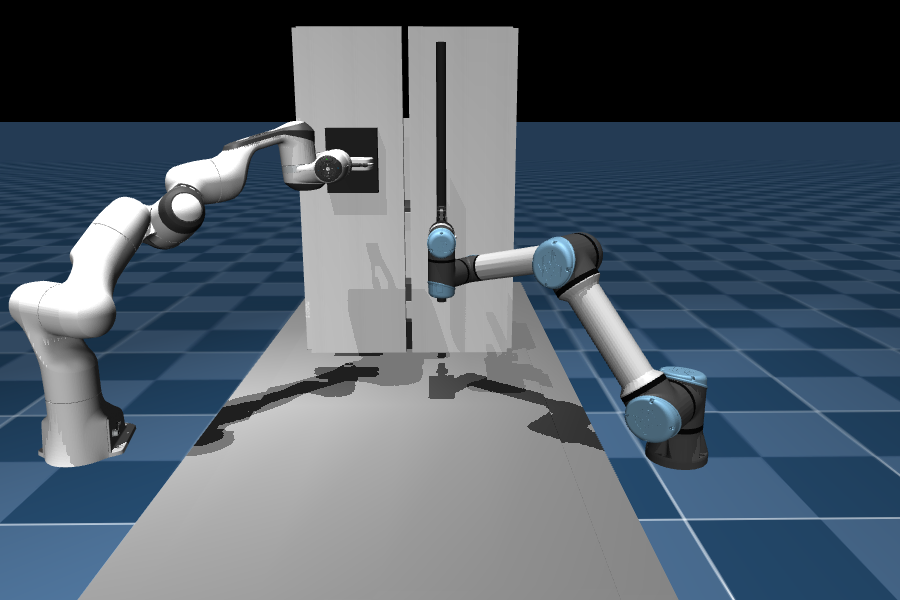

In [24]:
with task.physics.reset_context():
    task.physics.data.qpos[task.joint_ids["panda"]["qpos"]] = panda_trajectory[-1].cpu().detach().numpy()
    task.physics.data.qpos[task.joint_ids["ur5e"]["qpos"]] = trajectory_door.cpu().detach().numpy()

    task.physics.step()
    img = PIL.Image.fromarray(task.physics.render(camera_id=4, width = 900, height = 600))
img

In [36]:
## Use existing World Configs ##

## Doorhandle: UR5E, Keycard: Panda, Keyreader: Panda

def solve_mpc(physics, robot_file, robot_joint_ids, world_config, traj, tol = 1e-3):
    mpc_config = MpcSolverConfig.load_from_robot_config(
        robot_file,
        world_config,
        store_rollouts=True,
        step_dt=0.03,
    )
    mpc = MpcSolver(mpc_config)

    retract_cfg = mpc.rollout_fn.dynamics_model.retract_config.clone().unsqueeze(0)

    kinematics_state = mpc.rollout_fn.compute_kinematics(
        JointState.from_position(retract_cfg + 0.5, joint_names=mpc.joint_names)
    )
    
    goal_pose = kinematics_state.ee_pose.clone()


    ##Store idxs of qpos and ctrl
    qpos_ids = robot_joint_ids["qpos"]
    ctrl_ids = robot_joint_ids["ctrl"]



    # read start state from robot here:
    start_state = JointState.from_position(retract_cfg, joint_names=mpc.joint_names)

    goal = Goal(
        current_state=start_state,
        goal_state=JointState.from_position(retract_cfg, joint_names=mpc.joint_names),
        goal_pose=goal_pose,
    )

    goal_buffer = mpc.setup_solve_single(goal, 1)


    mpc.update_goal(goal_buffer)

    # using an iterator to prevent infinite loop
 

    for ep in range(len(traj)):
        i = 0
        while True and i < 100: # control loop

            # To change goal pose:
            # goal_buffer.goal_pose.copy_(new_pose) # for Cartesian Pose
            # mpc.enable_pose_cost(enable=True)
            # mpc.enable_cspace_cost(enable=False)
            new_goal_state = JointState.from_position(traj[ep].view(1, -1), joint_names=mpc.joint_names)
            goal_buffer.goal_state.copy_(new_goal_state) # for joint configuration
            mpc.enable_pose_cost(enable=False)
            mpc.enable_cspace_cost(enable=True)
            mpc.update_goal(goal_buffer)            

            # read current state from robot
            # current_state = your_robot_api.current_state() # convert to JointState
            current_state = JointState.from_position(
                torch.tensor([physics.data.qpos[qpos_ids].copy()], device=device).view(1, -1), 
                joint_names=mpc.joint_names)

            # run MPC:
            result = mpc.step(current_state)

            # send action to robot:
            command = result.action # Result is in JointState format
            # print(command)

            # your_robot_api.send_command(command)
            physics.data.ctrl[ctrl_ids] = command.position.cpu().detach().numpy()
            physics.step()
            
            print(result.metrics.pose_error.item())

            if result.metrics.pose_error.item() < tol:
                break

            # setting new current state from last command for this example:
            # comment this out and instead read state from your robot.
            # start_state = command
            start_state = JointState.from_position(
                torch.tensor([physics.data.qpos[qpos_ids].copy()], device=device).view(1, -1), 
                joint_names=mpc.joint_names)
            
            i += 1


## When running solve_mpc the pose_error is printed and seen going down

In [37]:
solve_mpc(task.physics, "franka_mobile.yml", task.joint_ids["panda"], panda_world_config.world_config, panda_trajectory, 6)
# solve_mpc(task.physics, "ur5e.yml", task.joint_ids["ur5e"], ur5e_world_config.world_config, ur5e_trajectory)

5.642315864562988
5.645371913909912
5.647657871246338
5.649328708648682
5.650518417358398
5.651318073272705
5.65179967880249
5.652024745941162
5.652040958404541
5.651886463165283
5.651595592498779
5.6511945724487305
5.650705814361572
5.650147914886475
5.649531364440918
5.648870468139648
5.648173809051514
5.64744758605957
5.646698951721191
5.645935535430908
5.645158290863037
5.644373893737793
5.643586158752441
5.6428022384643555
5.642024993896484
5.64125919342041
5.6405110359191895
5.639782905578613
5.639084815979004
5.638415813446045
5.637782573699951
5.637186050415039
5.636630058288574
5.636115074157715
5.6356377601623535
5.6352033615112305
5.634805679321289
5.6344451904296875
5.634121417999268
5.6338300704956055
5.633572101593018
5.6333417892456055
5.633137226104736
5.632959365844727
5.632806301116943
5.632671356201172
5.63255500793457
5.632457256317139
5.632374286651611
5.632307529449463
5.632248878479004
5.632204532623291
5.632166862487793
5.632139682769775
5.63211727142334
5.63210

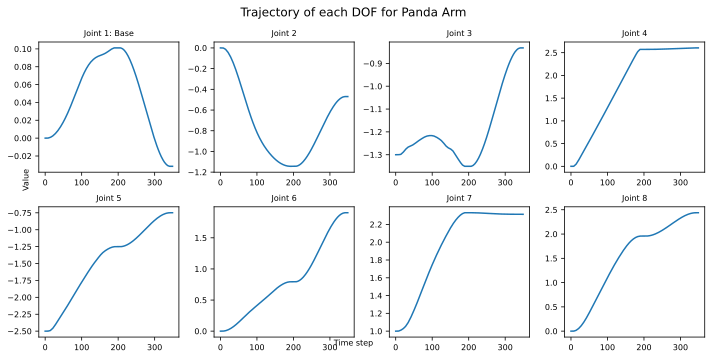

In [38]:
fig, ax = plt.subplots(2,4, figsize=(10,5))

for i in range(8):
    row = i //4 
    col = i % 4

    ax[row, col].plot(panda_trajectory[:, i].cpu().detach().numpy())
    if i == 0:
        ax[row, col].set_title(f"Joint {i+1}: Base")
    else:
        ax[row, col].set_title(f"Joint {i+1}")

# Set a common xlabel
fig.text(0.5, 0.04, 'Time step', ha='center')

# Set a common ylabel
fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

# Set a title for the whole figure
fig.suptitle('Trajectory of each DOF for Panda Arm')

# Layout the subplots
plt.tight_layout()
plt.savefig("panda_traj.png")
# Show the plot
plt.show()

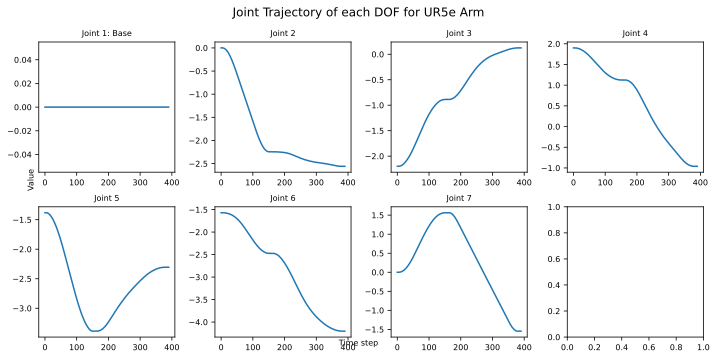

In [39]:
fig, ax = plt.subplots(2,4, figsize=(10,5))

for i in range(7):
    row = i //4 
    col = i % 4

    ax[row, col].plot(ur5e_trajectory[:, i].cpu().detach().numpy())
    if i == 0:
        ax[row, col].set_title(f"Joint {i+1}: Base")
    else:
        ax[row, col].set_title(f"Joint {i+1}")

# Set a common xlabel
fig.text(0.5, 0.04, 'Time step', ha='center')

# Set a common ylabel
fig.text(0.04, 0.5, 'Value', va='center', rotation='vertical')

# Set a title for the whole figure
fig.suptitle('Joint Trajectory of each DOF for UR5e Arm')

# Layout the subplots
plt.tight_layout()
plt.savefig("ur5e_traj.png")
# Show the plot
plt.show()